# Daegu Apartment: The Machine Learning Part

## Context
Please refer to 01_daegu_dataprep.ipynb for context and how the data is cleaned

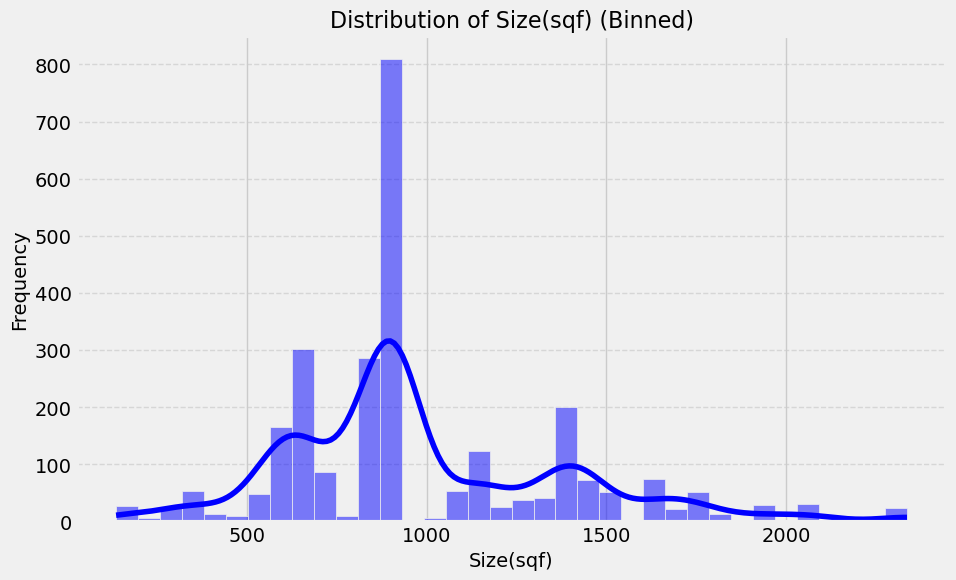

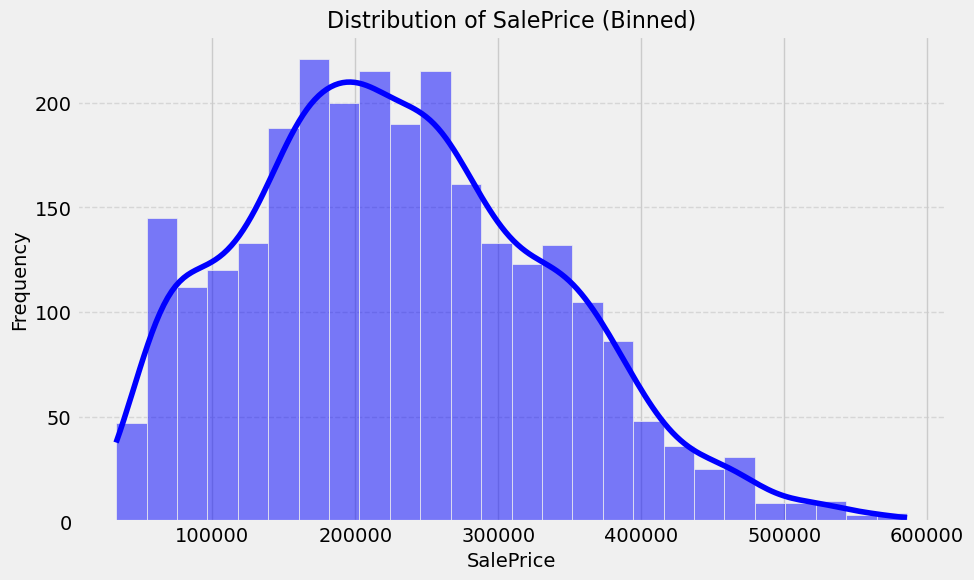

In [271]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
for column in numeric_columns:
    if df[column].nunique() >= 50:  # Only for numeric columns with unique values >= 50
        data = df[column].dropna()
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        bin_width = 2 * iqr / len(data)**(1/3)
        bins = int((data.max() - data.min()) / bin_width)

        plt.figure(figsize=(10, 6))
        sns.histplot(data, kde=True, bins=bins, color='blue')
        plt.title(f'Distribution of {column} (Binned)', fontsize=16)
        plt.xlabel(column, fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()


# 3. Machine Learning Algorithm Election Day

## Import Machine Learning libraries

In [23]:
# Data Preprocessing
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    RobustScaler, 
    MinMaxScaler, 
    StandardScaler
)
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

# Model Selection & Evaluation
from sklearn.model_selection import (
    train_test_split, 
    KFold, 
    cross_validate, 
    cross_val_score, 
    GridSearchCV
)
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    mean_absolute_error
)

# Regression Models
from sklearn.linear_model import (
    LinearRegression, 
    Lasso, 
    Ridge, 
    ElasticNet
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Ensemble Models
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    StackingRegressor, 
    ExtraTreesRegressor, 
    AdaBoostRegressor
)

# Boosting Libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

# Visualization & Utilities
import shap
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


## Feature Selection & Engineering

###  3.1. Data Loading and Preproessing

In [27]:
# Load the dataset
dataset_path = 'df.csv'
df = pd.read_csv(dataset_path)

# Preprocessing Data
def preprocess_data(df):
    # Feature Engineering
    # Contoh: Membuat fitur baru seperti price_per_sqm
    df['price_per_sqm'] = df['SalePrice'] / df['Size(sqf)']
    from sklearn.preprocessing import OrdinalEncoder

    ordinal_encoder = OrdinalEncoder()
    df['TimeToSubway'] = ordinal_encoder.fit_transform(df[['TimeToSubway']])
    df = pd.get_dummies(df, columns=['SubwayStation', 'HallwayType'], drop_first=True)
    
    return df

df_processed = preprocess_data(df)


# Define feature columns
numerical_cols = [
    'N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)',
    'N_SchoolNearBy(University)', 'N_Parkinglot(Basement)', 'YearBuilt',
    'N_FacilitiesInApt', 'Size(sqf)', 'price_per_sqm', 'TimeToSubway'
]

categorical_cols = ['SubwayStation', 'HallwayType']

# Apply column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

print("Preprocessing setup complete!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Preprocessing setup complete!


### 3.2. Split the Data

into training and testing sets

In [35]:
# Define features and target variable
X = df_processed.drop('SalePrice', axis=1)
y = df_processed['SalePrice']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.3. Feature Scaling

We use RobustScaler because the distribution of variables is not Gaussian

In [37]:
# Scaling features using MinMaxScaler for normalization
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 3.4. Model Training with Hyperparameter Tuning

In [39]:
# Define models and their parameter grids
models = {
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror')
}

params = {
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    'Ridge': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    'Random Forest': {'n_estimators': [10, 50, 100, 200]},
    'Gradient Boosting': {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [100, 200]},
    'SVR': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']},
    'Decision Tree': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 10, 20]},
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1],
        'colsample_bytree': [0.3, 0.5, 0.7]
    }
}

results = {}
    
# Perform GridSearchCV for hyperparameter tuning
for name, model in models.items():
    grid = GridSearchCV(model, params[name], cv=5, scoring='neg_mean_squared_error', verbose=1)
    grid.fit(X_train_scaled, y_train)
    results[name] = {
        'model': grid.best_estimator_,
        'score': grid.best_score_,
        'params': grid.best_params_
    }
    print(f"{name} Best Score: {grid.best_score_}")
    print(f"{name} Best Parameters: {grid.best_params_}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Lasso Best Score: -815245060.4478866
Lasso Best Parameters: {'alpha': 0.001}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Ridge Best Score: -815245048.4005234
Ridge Best Parameters: {'alpha': 0.001}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Random Forest Best Score: -37932939.8672324
Random Forest Best Parameters: {'n_estimators': 50}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Gradient Boosting Best Score: -43533762.848360755
Gradient Boosting Best Parameters: {'learning_rate': 0.5, 'n_estimators': 200}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVR Best Score: -7554204751.815005
SVR Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Decision Tree Best Score: -68263901.71805556
Decision Tree Best Parameters: {'max_depth': 30, 'min_samples_split': 2}
Fitting 5 folds for each of 243 candi

### 3.5. Evaluate models using test data

In [41]:
for name, info in results.items():
  
    # Prediksi
    y_pred = info['model'].predict(X_test_scaled)
    
    # Evaluasi
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'RMSE': rmse,
        'R2': r2,
        'MAE': mae
    }
    
    print(f"\nHasil Evaluasi {name}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    print(f"MAE: {mae:.2f}")


metrics_df = pd.DataFrame({
    name: {'RMSE': info['RMSE'], 'R2': info['R2'], 'MAE': info['MAE']}
    for name, info in results.items()
}).T

# Sort models based on RMSE (ascending order - lower RMSE is better)
ranked_by_rmse = metrics_df.sort_values(by='RMSE', ascending=True)

# Sort models based on R2 (descending order - higher R2 is better)
ranked_by_r2 = metrics_df.sort_values(by='R2', ascending=False)

# Sort models based on MAE (ascending order - lower MAE is better)
ranked_by_mae = metrics_df.sort_values(by='MAE', ascending=True)

# Display the rankings
print("\n### Models Ranked by RMSE (Best to Worst):")
print(ranked_by_rmse)

print("\n### Models Ranked by R2 Score (Best to Worst):")
print(ranked_by_r2)

print("\n### Models Ranked by MAE (Best to Worst):")
print(ranked_by_mae)

<IPython.core.display.Javascript object>


Hasil Evaluasi Lasso:
RMSE: 26504.18
R2 Score: 0.93
MAE: 19367.84


<IPython.core.display.Javascript object>


Hasil Evaluasi Ridge:
RMSE: 26504.20
R2 Score: 0.93
MAE: 19367.90


<IPython.core.display.Javascript object>


Hasil Evaluasi Random Forest:
RMSE: 5822.44
R2 Score: 1.00
MAE: 2586.99


<IPython.core.display.Javascript object>


Hasil Evaluasi Gradient Boosting:
RMSE: 4912.14
R2 Score: 1.00
MAE: 3357.40


<IPython.core.display.Javascript object>


Hasil Evaluasi SVR:
RMSE: 82442.93
R2 Score: 0.36
MAE: 66022.22


<IPython.core.display.Javascript object>


Hasil Evaluasi Decision Tree:
RMSE: 6710.39
R2 Score: 1.00
MAE: 3171.94


<IPython.core.display.Javascript object>


Hasil Evaluasi XGBoost:
RMSE: 4298.91
R2 Score: 1.00
MAE: 2683.28


<IPython.core.display.Javascript object>


### Models Ranked by RMSE (Best to Worst):
                           RMSE        R2           MAE
XGBoost             4298.908233  0.998260   2683.282167
Gradient Boosting   4912.142549  0.997729   3357.399094
Random Forest       5822.444768  0.996809   2586.989020
Decision Tree       6710.386926  0.995761   3171.939002
Lasso              26504.181537  0.933871  19367.837266
Ridge              26504.197233  0.933871  19367.904645
SVR                82442.932761  0.360160  66022.221815

### Models Ranked by R2 Score (Best to Worst):
                           RMSE        R2           MAE
XGBoost             4298.908233  0.998260   2683.282167
Gradient Boosting   4912.142549  0.997729   3357.399094
Random Forest       5822.444768  0.996809   2586.989020
Decision Tree       6710.386926  0.995761   3171.939002
Lasso              26504.181537  0.933871  19367.837266
Ridge              26504.197233  0.933871  19367.904645
SVR                82442.932761  0.360160  66022.221815

### Models 

All models except SVR have R2 score nearing 1. 
Lasso, RIdge, and SVR has high RMSE.
So we will only use XGBoost, Gradient Boosting, and Random forest
Models predict price more accurately by lower RMSE.  
Therefore, we shall use XGBoost for the best model

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline


# List of pipelines and model names
pipelines = {
    "Random Forest": rf_pipeline,
    "Gradient Boosting": gb_pipeline,
    "Decision Tree": dt_pipeline,
    "XGBoost": xgb_pipeline
}

# Dictionary to store residuals and feature importances
results = {}

# Generate residual plots and calculate feature importance
for name, pipeline in pipelines.items():
    print(f"\n{name} Model Evaluation:")
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    residuals = y_test - y_pred

    # Residual plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residual Plot for {name}')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    
    # Store residuals for analysis
    results[name] = {"residuals": residuals, "rmse": rmse, "r2": r2, "mae": mae}
    

results_df = pd.DataFrame(model_results).sort_values(by='RMSE', ascending=True)

# Display comparison results
print("\n### Model Comparison Results ###")
print(results_df)

# Highlight the best model
best_model = results_df.loc[results_df['RMSE'].idxmin()]

print(f"\nThe best model is: {best_model['model_name']} with RMSE: {best_model['RMSE']:.2f}, R²: {best_model['R2']:.4f}, and MAE: {best_model['MAE']:.2f}")


NameError: name 'rf_pipeline' is not defined

### 3.6. Feature Importance

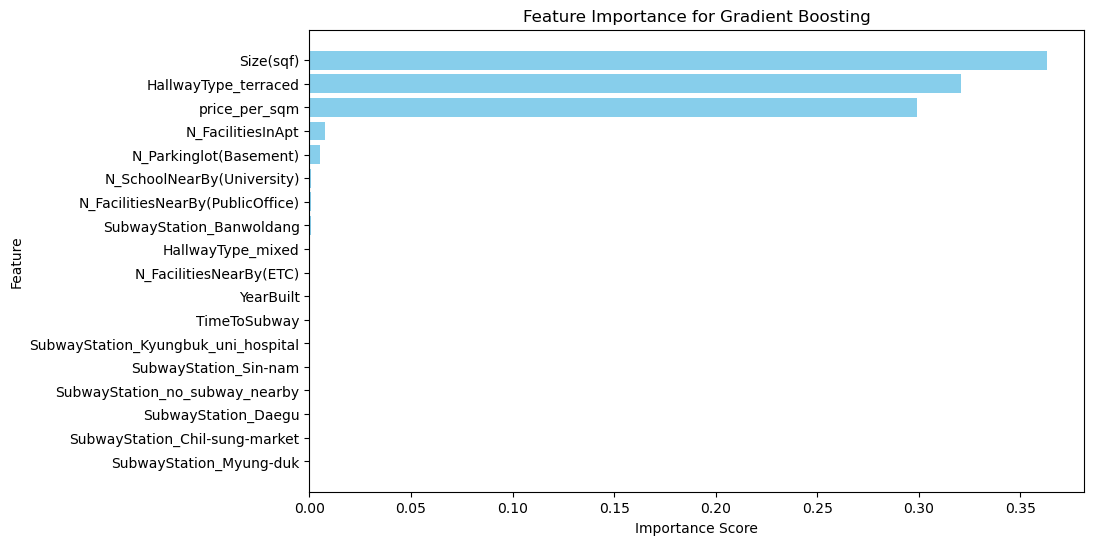

In [255]:
# Feature importance for Gradient Boosting
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming `best_model` is the trained Gradient Boosting model
best_model = GradientBoostingRegressor(learning_rate=0.5, n_estimators=200)
best_model.fit(X_train_scaled, y_train)

# Extract feature importance
feature_importance = best_model.feature_importances_
features = X_train.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.title('Feature Importance for Gradient Boosting')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


### 3.7. Save to Pickle

In [3]:
import pickle

# Save the best model to a pickle file
with open('best_gradient_boosting_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Best model saved to 'best_gradient_boosting_model.pkl'")


NameError: name 'best_model' is not defined